In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_multiotsu, rank
from skimage.filters import sobel


'''
"Amyg_CE_right_glass_23_rat_20_amy_right_skan_2019-10-15_142619" +
"CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039" - 
'''
scan_name = "DG_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039"

path_comm = "/home/ula/catfish/test_scans/" + scan_name + "/"
path_orig = path_comm + "orig.tif"

dapi_path = path_comm + "1.tif"
homer_path = path_comm + "2.tif"
arc_path = path_comm + "3.tif"

In [2]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + (1-frac)*(max_lum - min_lum)

In [3]:
class Nucleus(): 
    def __init__(self, nucelusProps, approxEllipse,  idno):
        self.nucelusProps = nucelusProps
        self.approxEllipse = approxEllipse
        self.idno = idno
   

In [4]:
def quantile_wrapper(image):
    return np.quantile(image, 0.99)

In [5]:
def custom_thre(image, frac):
    block_size = 150
    overlap = 70
    
    x = 0
    thre_map = np.zeros_like(image)
    while x < thre_map.shape[0]:
        prev_x = x
        x = min(x + block_size, thre_map.shape[0])
        y = 0
        while y < thre_map.shape[1]:
            prev_y = y
            y = min(y + block_size, thre_map.shape[1])
            subimage = image[prev_x:x, prev_y:y]
            if np.count_nonzero(subimage) > 0:
                thre_map[prev_x:x, prev_y:y] = np.quantile(subimage, frac)
    thre_map = ndi.gaussian_filter(thre_map, 30)
    return thre_map
            

In [6]:
def ieg_segmentation(image_ts, thresh_down, thresh_up, thresh_range, background_cutoff): 

    c_thre = custom_thre(image_ts, background_cutoff)
    
    thre_eq = c_thre - np.min(c_thre)
    mask = image_ts > (np.quantile(image_ts[image_ts>0], background_cutoff) + thre_eq)
    #mask = rank.otsu(image_ts, disk(50))
    mask = image_ts > threshold_otsu(image_ts[image_ts>0])+ thre_eq
    elev_map = sobel(image_ts)
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((2,2)),
                                labels=mask)
    markers = ndi.label(local_maxi)[0]

   
    labels = watershed(-elev_map, markers, mask=mask)

    label_image = label(labels, connectivity = 1)
    
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True)
    ax = axes.ravel()
    
    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(labels)
    ax[1].set_title("labels")
    
    ax[2].imshow(image_ts)
    ax[2].set_title("orig img")
    
    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

    
    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Circle((region.centroid[1], region.centroid[0]), 5, 
                               fill=False, edgecolor='red', linewidth=2)
        if region.area >= thresh_up:
            ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)    
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, areas

In [7]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    image_ts_orig = copy.copy(image_ts)
    
    image_ts = opening(image_ts, disk(2))
    
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True)
    ax = axes.ravel()
    fig.set_figwidth(10)
    thresh = threshold_otsu(image_ts[image_ts>0])/2
    #closed = closing(image_ts > T_mean, disk(11))
    thresholds = threshold_multiotsu(image_ts)

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, 
                                             mask = ~(image_ts > thresh), fill_value = 0).filled()

    local_masked_global = opening(local_masked_global, disk(5))
    elev_map = sobel(mh.gaussian_filter(image_ts,3))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    ax[0].imshow(local_masked_global)
    ax[0].set_title("local_masked_global")
    

    label_image = label(labels, connectivity = 1)

    #ax[0].imshow(label_image)
    #ax[0].set_title("Labelled")
    ax[1].imshow(image_ts_orig)
    ax[1].set_title("Labelled")
    


    ax[2].imshow(image_ts)
    ax[2].set_title("orig img")


    extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(path_comm + 'labelled.tif', bbox_inches=extent)
    
    areas = np.array([])
    intensities = np.array([])
    
    regions_to_reconsider = []

    for region in regionprops(label_image, intensity_image=image_ts):
        areas = np.append(areas, region.area)
        intensities = np.append(intensities, region.mean_intensity)

    std = np.std(areas)
    mean = np.mean(areas)
    

    nuclei = np.array([])
    for region in regionprops(label_image):
        if region.area >= thresh_down:
            approxEllipse = mpatches.Ellipse((region.centroid[1],region.centroid[0]), region.minor_axis_length,
                                                             region.major_axis_length,(-180/math.pi)*(region.orientation),
                           fill=False, edgecolor='red', linewidth=1)
            new_nucleus = Nucleus(region, copy.copy(approxEllipse), len(nuclei))
            nuclei = np.append(nuclei, new_nucleus)      
            ax[1].add_patch(approxEllipse)
 
    
    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    
    
    return nuclei, regions_to_reconsider, label_image

<IPython.core.display.Javascript object>


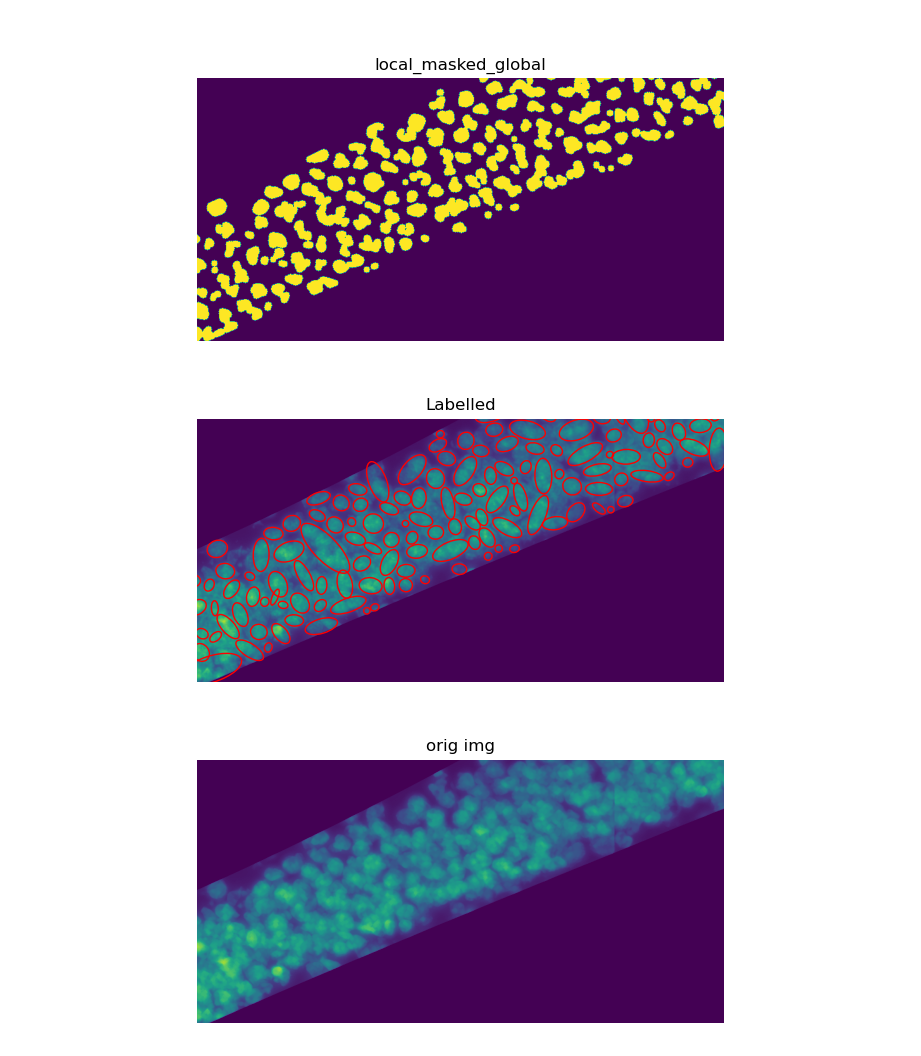

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3222


In [12]:
image = io.imread(dapi_path)
nuclei, thresholded,_ = dapi_segmentation(image,10, 75, 1250, 49)
print(len(nuclei))


In [9]:
arc_im = io.imread(arc_path)
#homer_im = io.imread(homer_path)


arc_locations, _,areas = ieg_segmentation(arc_im, 0, 30, 21, 0.75)
#homer_locations, _,_ = ieg_segmentation(homer_im, 0, 30, 21, 0.75)

/home/ula/anaconda3/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>

In [10]:
def prepare_coords_set(coords_tab):
    return set(tuple([m, n]) for m, n in zip(coords_tab[:,0], coords_tab[:,1]))

def find_ieg_colloc(ieg_locs, nuclei, to_reevaluate):
    ieg_positive = np.array([])
    fig, ax = plt.subplots(figsize=(6, 6))
    full_image = io.imread(path_orig)
    ax.imshow(full_image)
    counter = 0
    for nucleus in nuclei:
        nucleus_patch = copy.copy(nucleus.approxEllipse)
        ieg_no = 0
        if counter %100 == 0:
            print(counter)
        counter += 1
        for ieg_dot in ieg_locs:
            ieg_centroid = ieg_dot.centroid      
            #if the centroid of area identified as immediate early gene presence is inside of nucleus, add it
            #to the number of ieg collocalized with the nucleus
            
            tmp = nucleus.approxEllipse.contains_point((ieg_centroid[1], ieg_centroid[0]))
            
            if (tmp):
                ieg_no +=1
                if ieg_no == 1:
                    ieg_positive = np.append(ieg_positive, nucleus.idno)
                     
                    minr, minc, maxr, maxc = ieg_dot.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='red', linewidth=1)
                    
                    nucleus_patch.set_color('white')
                    #ax.add_patch(rect)   
        if ieg_no > 1:
            to_reevaluate = np.append(to_reevaluate, nucleus)
        ax.add_patch(nucleus_patch)   
    ax.set_axis_off()

    fig.tight_layout()
    plt.title("colloc")
    plt.show()
    return ieg_positive, to_reevaluate

In [11]:
to_reevalueate = []

arc_pos, arc_mult =  find_ieg_colloc(arc_locations, nuclei, to_reevalueate)
homer_pos, homer_mult =  find_ieg_colloc(homer_locations, nuclei, to_reevalueate)

print('arc len ', len(arc_pos), len(arc_mult))
print('homer len ', len(homer_pos),len(homer_mult))


<IPython.core.display.Javascript object>

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


KeyboardInterrupt: 

In [ ]:
image = io.imread(dapi_path)
print(np.max(image))
plt.ioff()
local_thresh = threshold_local(image, 149, offset=0)
#thresholds = threshold_multiotsu(image[image>local_thresh])


#for thresh in thresholds:
#    plt.axvline(thresh, color='r')
print(threshold_otsu(image[image>0]), threshold_otsu(image))
#plt.axvline(threshold_otsu(image), color='red')
#plt.axvline(np.median(image), color='green')


#plt.axvline(np.quantile(image, 0.99), color='pink')
#plt.axvline(np.quantile(image[image>0], 0.99), color='black')
hist = plt.hist(image[image>local_thresh/2].flatten(), 255)
plt.show()

image = io.imread(dapi_path)

In [ ]:
from skimage.feature import blob_dog, blob_log, blob_doh

subimage = image[1300:1500, 4300:4600]
dapi_segmentation(subimage, 4, 10, 1250, 49)
im_bw = subimage>threshold_otsu(subimage)/1.5
blobs = blob_log(im_bw, max_sigma=30, min_sigma = 3, num_sigma=6, threshold=0.3, overlap = 0.5)
fig, ax = plt.subplots()
ax.imshow(im_bw, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))
plt.show()
plt.imshow(subimage)
plt.show()

In [ ]:
im = 255-rgb2gray(io.imread('../../Downloads/index.png'))
dapi_segmentation(im, 4, 60, 1250, 49)

In [ ]:
angle_step = 30  # degrees
angles = np.arange(0, 360, angle_step)

ax = plt.subplot(aspect='equal')
step_x = 3
step_y = 3
x = 0
y = 0
for angle in angles:
    ellipse = mpatches.Ellipse((x,y), 2, 4, angle=angle, alpha=0.1)
    x += step_x
    y += step_y
    ax.add_artist(ellipse)
    print(ellipse.)

plt.xlim(-5, 40)
plt.ylim(-5, 40)

plt.show()
